# Computer vision with torchvision: 

Computer vision is the art of teaching a computer how to see and understand what it sees.

Or whether a photo is of a cat, dog or chicken (multi-class classification).

Or identifying where a car appears in a video frame (object detection).

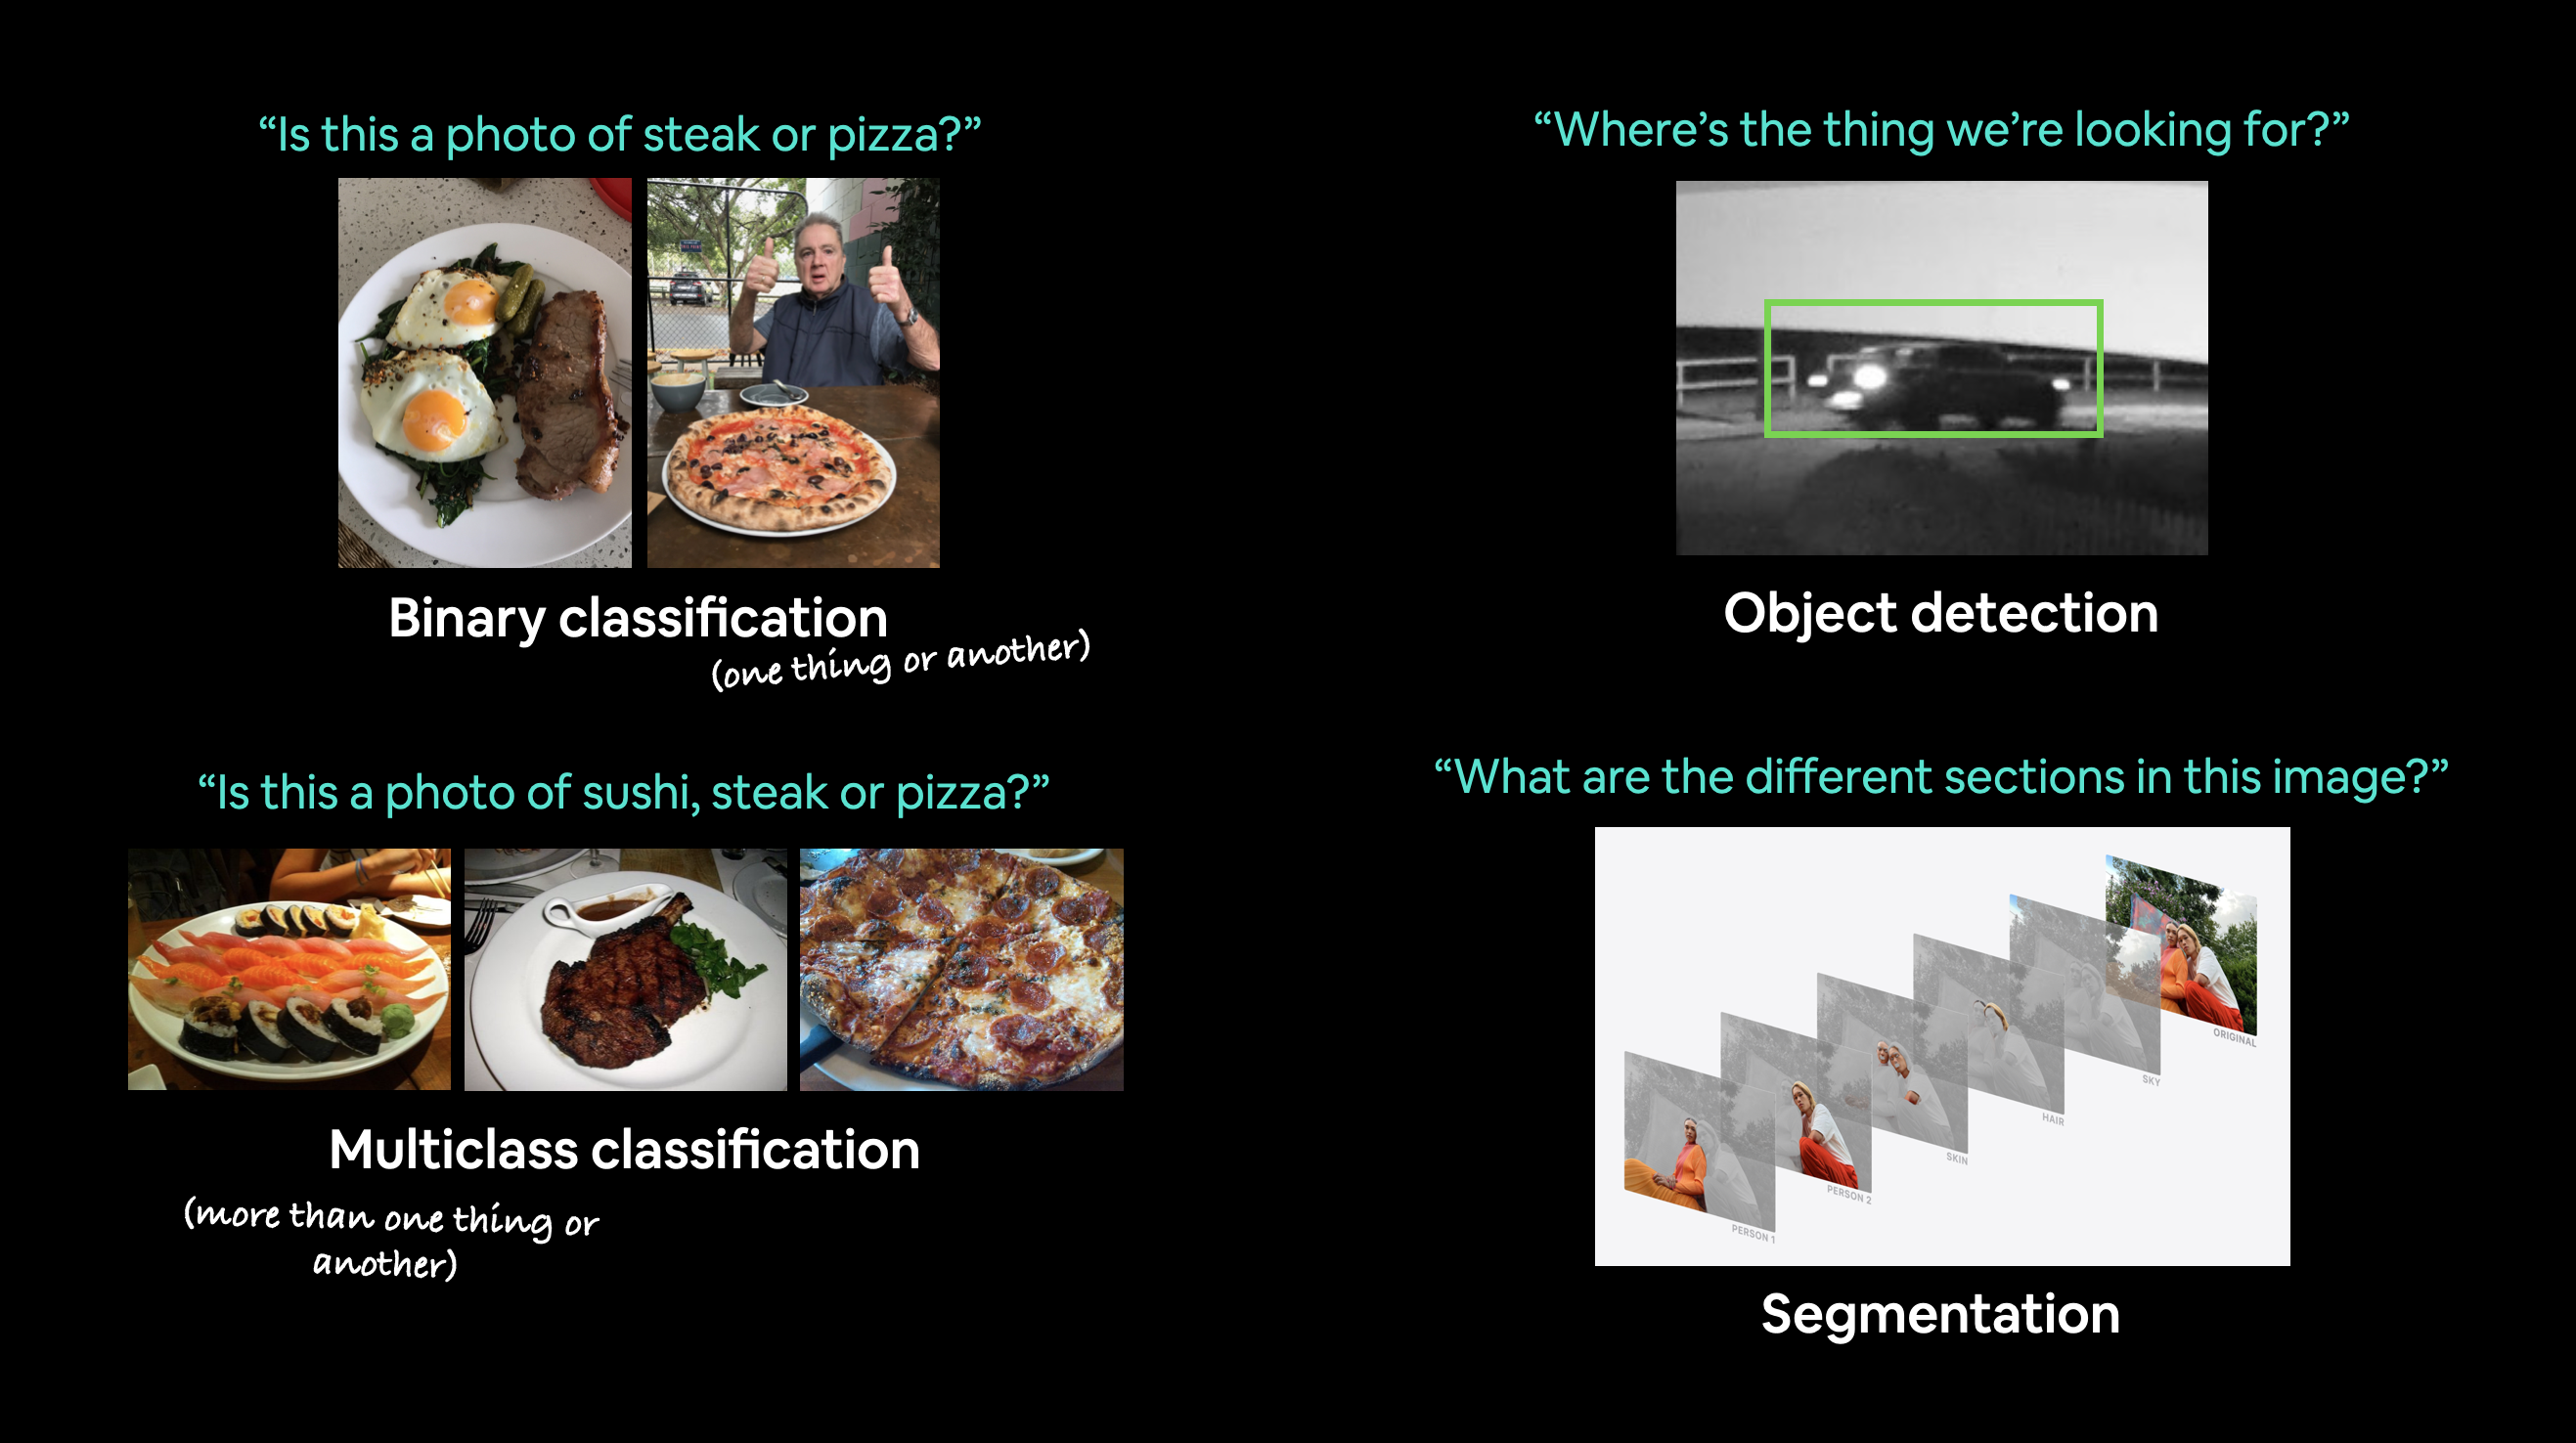

This notebook is split on these sections: 



*   **0. Computer Vision lebraries in pytorch.**

*   **1. Load Data.**

*   **2. Prepare the Data.**

*   **3. Building a baseline model(Model0).**
*   **4. Making predictions and evaluating model0.**


*   **5. Setup Device agnostic code.**


*   **6. Model1 : adding non.linearity.**


*   **7. Creating a CNN Model.**
*   **8. Training the model.**
*   **9. Evaluation the model.**
*   **10. Saving and loading the model.**



# 0. Computer vision lebraries in Pytorch: 

Pytorch offers a great library for computer vision ,[torchvision](https://pytorch.org/vision/stable/index.html), so you can find tha datasets like the one we are going to use in [torchvision.datasets](https://pytorch.org/vision/stable/datasets.html). Torchvision also has a list of pretrained models in [torchvision.models](https://pytorch.org/vision/stable/models.html), this notebook also covers [torchvision.tranforms](https://pytorch.org/vision/stable/transforms.html) which is used to make some transformations on the data, and [torchvision.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html) to Load our data in batch or mini-batch format.

---



In [1]:
# Importing usefull libraries for computer vision

import torch
import torch.nn as nn 

import torchvision 
from torchvision import datasets
from torch.utils.data import DataLoader 
from torchvision.transforms import ToTensor


# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")


PyTorch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


# 1. Get the Data: 

We are going to load the MNISTFashion dataset, which is a bunch a 28*28 pixel images represinting 10 classes of cloths. You can find the dataset under [torchvision.datasets.FashionMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).

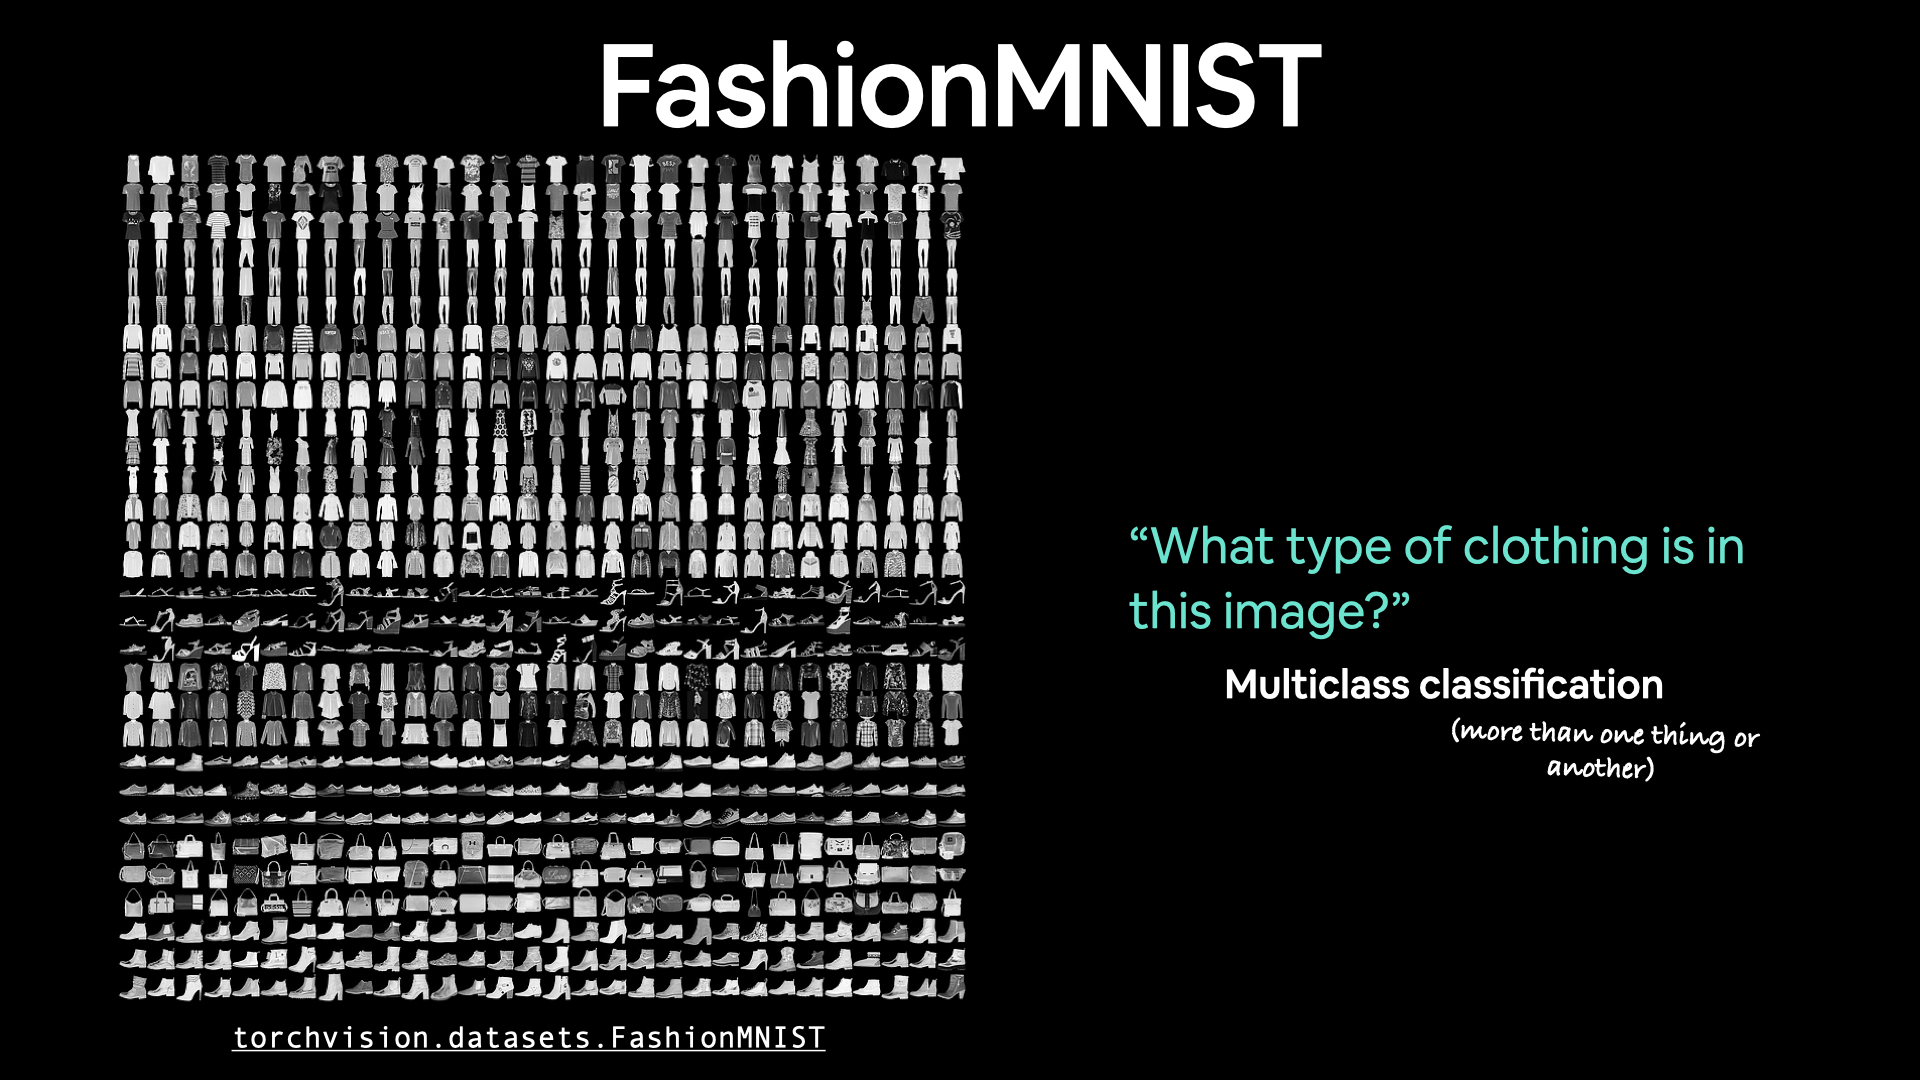

In [2]:
# Getting training Data

train_data = datasets.FashionMNIST(
    root = "data", # Where you want to store the data.
    train = True, # We are getting the training data.
    download = True, # gets the data is it doesn't exist already.
    transform= ToTensor(), # Images comes in PIL format, but we are using torch tensors to compute. 
)

# Loading the test data.

test_data = datasets.FashionMNIST(
    root = "data",
    train = False, # cuz its the testing data.
    download = True,
    transform = ToTensor(), 

)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Let's see the length of the dataset and different shapes.


In [3]:
print(f"The train data has {len(train_data)}/ and the test data has {len(test_data)} images ")

# Images and labels shape

image, label = train_data[0]

print(f"Images shape : {image.shape} /, and the label shape ")

The train data has 60000/ and the test data has 10000 images 
Images shape : torch.Size([1, 28, 28]) /, and the label shape 



The shape of the image tensor is [1, 28, 28] or more specifically:

[color_channels=1, height=28, width=28],

Having a color_channel = 1 means the image is grayscale.

In [4]:


# How many samples are there? 
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

We can see the classes name by .classes attribute.

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

**Data visualization:**

Visualize the first image of the train data. 



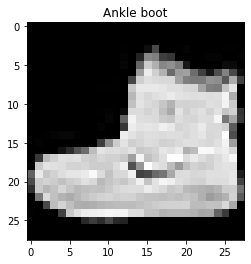

In [6]:
plt.imshow(image.squeeze(), cmap = "gray")# We squeeze the image cuz its shape i so [1, 28, 28]
plt.title(class_names[label]);

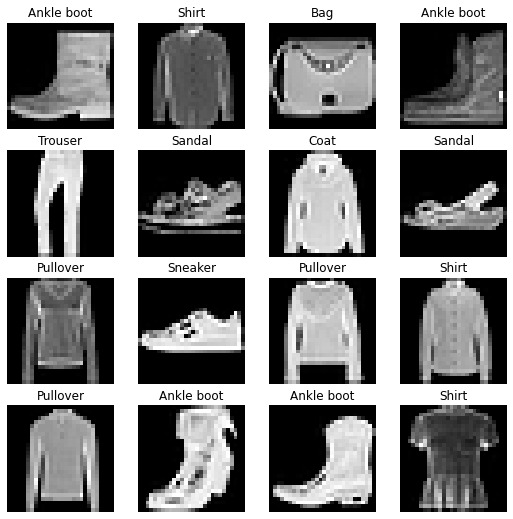

In [7]:
# lets visualize a bunch of images 

torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

# 2. Getting the data ready.

We are going to load the data in batches of 32, so the model doean't take much time cumputing.

In [8]:
BATCH_SIZE = 32 

# Using DataLoaders

train_dl = DataLoader(
    train_data, # dataset to turn into iterable
    batch_size = BATCH_SIZE, # How many images per batch 
    shuffle = True, # we shuffle the data before loading abatch of it.
)


test_dl = DataLoader(
    test_data, # dataset to turn into iterable
    batch_size = BATCH_SIZE, # How many images per batch 
    shuffle = False, # we dont need to shuffle it for testing.
)


# Let's check out what we've created
print(f"Dataloaders: {train_dl, test_dl}") 
print(f"Length of train dataloader: {len(train_dl)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dl)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f004c9921f0>, <torch.utils.data.dataloader.DataLoader object at 0x7f004c992400>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [9]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dl))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


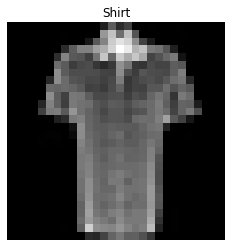

In [10]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

# 3. Model Baseline.
First we need to create a baseline model(model0), only with linear layers and add more complexity later. Before we need to use a fallten layer which takes and image in it's original shpae [1,28,28] and return a tensor in a this shape [1, 784]->[1, 28*28] so it can be given to the model. 

In [11]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
print(x)
print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 

**Now we Build a basic baseline model.**

In [12]:
# WE subclassing nn.Module.
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)
        

Let's create an instance of our class and take it to a cpu and train it so be can compare between cpu and gpu computational speed:

In [13]:
# Create model 

model_0 = FashionMNISTModelV0(input_shape = 28*28, # because the fllaten image comes in a shape of [1, 28*28]
                              hidden_units = 10,# lets start with a simple 10 neurons.
                              output_shape = len(class_names)# the model need to output a prediction for everx class 
                              ).to("cpu")
                              

Now we need a helper function form the Pytorch script:


In [14]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

And now we use the helper function to get an accuracy function to evaluate our model in a human readable format.

In [15]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy()

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

To be able to track the time our model takes to compute we need to use timeit module.

In [16]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time


**It's time to train the model and track the time it takes on a cpu.**

In [17]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dl):
        model_0.train() 
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dl.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dl)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dl:
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dl)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dl)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59484 | Test loss: 0.51635, Test acc: 81.84%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47946 | Test loss: 0.48138, Test acc: 83.18%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45703 | Test loss: 0.47773, Test acc: 83.50%

Train time on cpu: 26.192 seconds


Bloody nice! 
looks like we good a fairly good accuracy for two linear layers and 3 epochs.

And we can see that it took 30 seconds to compute on a cpu.

# 4. Make predictions and get Model 0 results


Namely, let's create a function that takes in a trained model, a DataLoader, a loss function and an accuracy function.

The function will use the model to make predictions on the data in the DataLoader and then we can evaluate those predictions using the loss function and accuracy function.

In [18]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dl,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4777321219444275,
 'model_acc': 83.49640575079871}

# 4. Using agnostic device.

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 5. Adding non linearity to the model.

Should you use non linearity function ReLu() for this dataset. As we have een machine learning is partly art, so we need to expirement to find out.

So let's add non-linear layers to the model.

In [20]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [21]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(class_names) # number of output classes desired
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

**Setup loss, optimizer and metric function.**

In [22]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

**Training part:**

So far we've been writing train and test loops over and over.

Let's write them again but this time we'll put them in functions so they can be called again and again.

And because we're using device-agnostic code now, we'll be sure to call .to(device) on our feature (X) and target (y) tensors.

For the training loop we'll create a function called train_step() which takes in a model, a DataLoader a loss function and an optimizer.

The testing loop will be similar but it'll be called test_step() and it'll take in a model, a DataLoader, a loss function and an evaluation function.

In [23]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

Now let's train this model and track the time to compre it the the first model on the cpu.

In [24]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dl, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dl,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.95636 | Test accuracy: 65.00%

Epoch: 1
---------
Train loss: 0.78101 | Train accuracy: 71.93%
Test loss: 0.72227 | Test accuracy: 73.91%

Epoch: 2
---------
Train loss: 0.67027 | Train accuracy: 75.94%
Test loss: 0.68500 | Test accuracy: 75.02%

Train time on cuda: 30.343 seconds


We can see that the model took longer to train and got less test accuracy, that means non-linearity isn's a great idea.

Now we need to change the evalution function to use the used device:

In [25]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=model_1, data_loader=test_dl,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [26]:
# Check baseline results
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4777321219444275,
 'model_acc': 83.49640575079871}

**From the looks of things, it seems like our model is overfitting on the training data.

Overfitting means our model is learning the training data well but those patterns aren't generalizing to the testing data.

Two of the main to fix overfitting include:**



1.   Using a smaller or different model (some models fit certain kinds of data better than others).
2.   Using a larger dataset (the more data, the more chance a model has to learn generalizable patterns).



# 5. Model 2: Building a Convolutional Neural Network (CNN):


It's time to create a Convolutional Neural Network (CNN or ConvNet).

CNN's are known for their capabilities to find patterns in visual data.

And since we're dealing with visual data, let's see if using a CNN model can improve upon our baseline.

The CNN model we're going to be using is known as TinyVGG from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

It follows the typical structure of a convolutional neural network:

Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer

Where the contents of [Convolutional layer -> activation layer -> pooling layer] can be upscaled and repeated multiple times, depending on requirements.

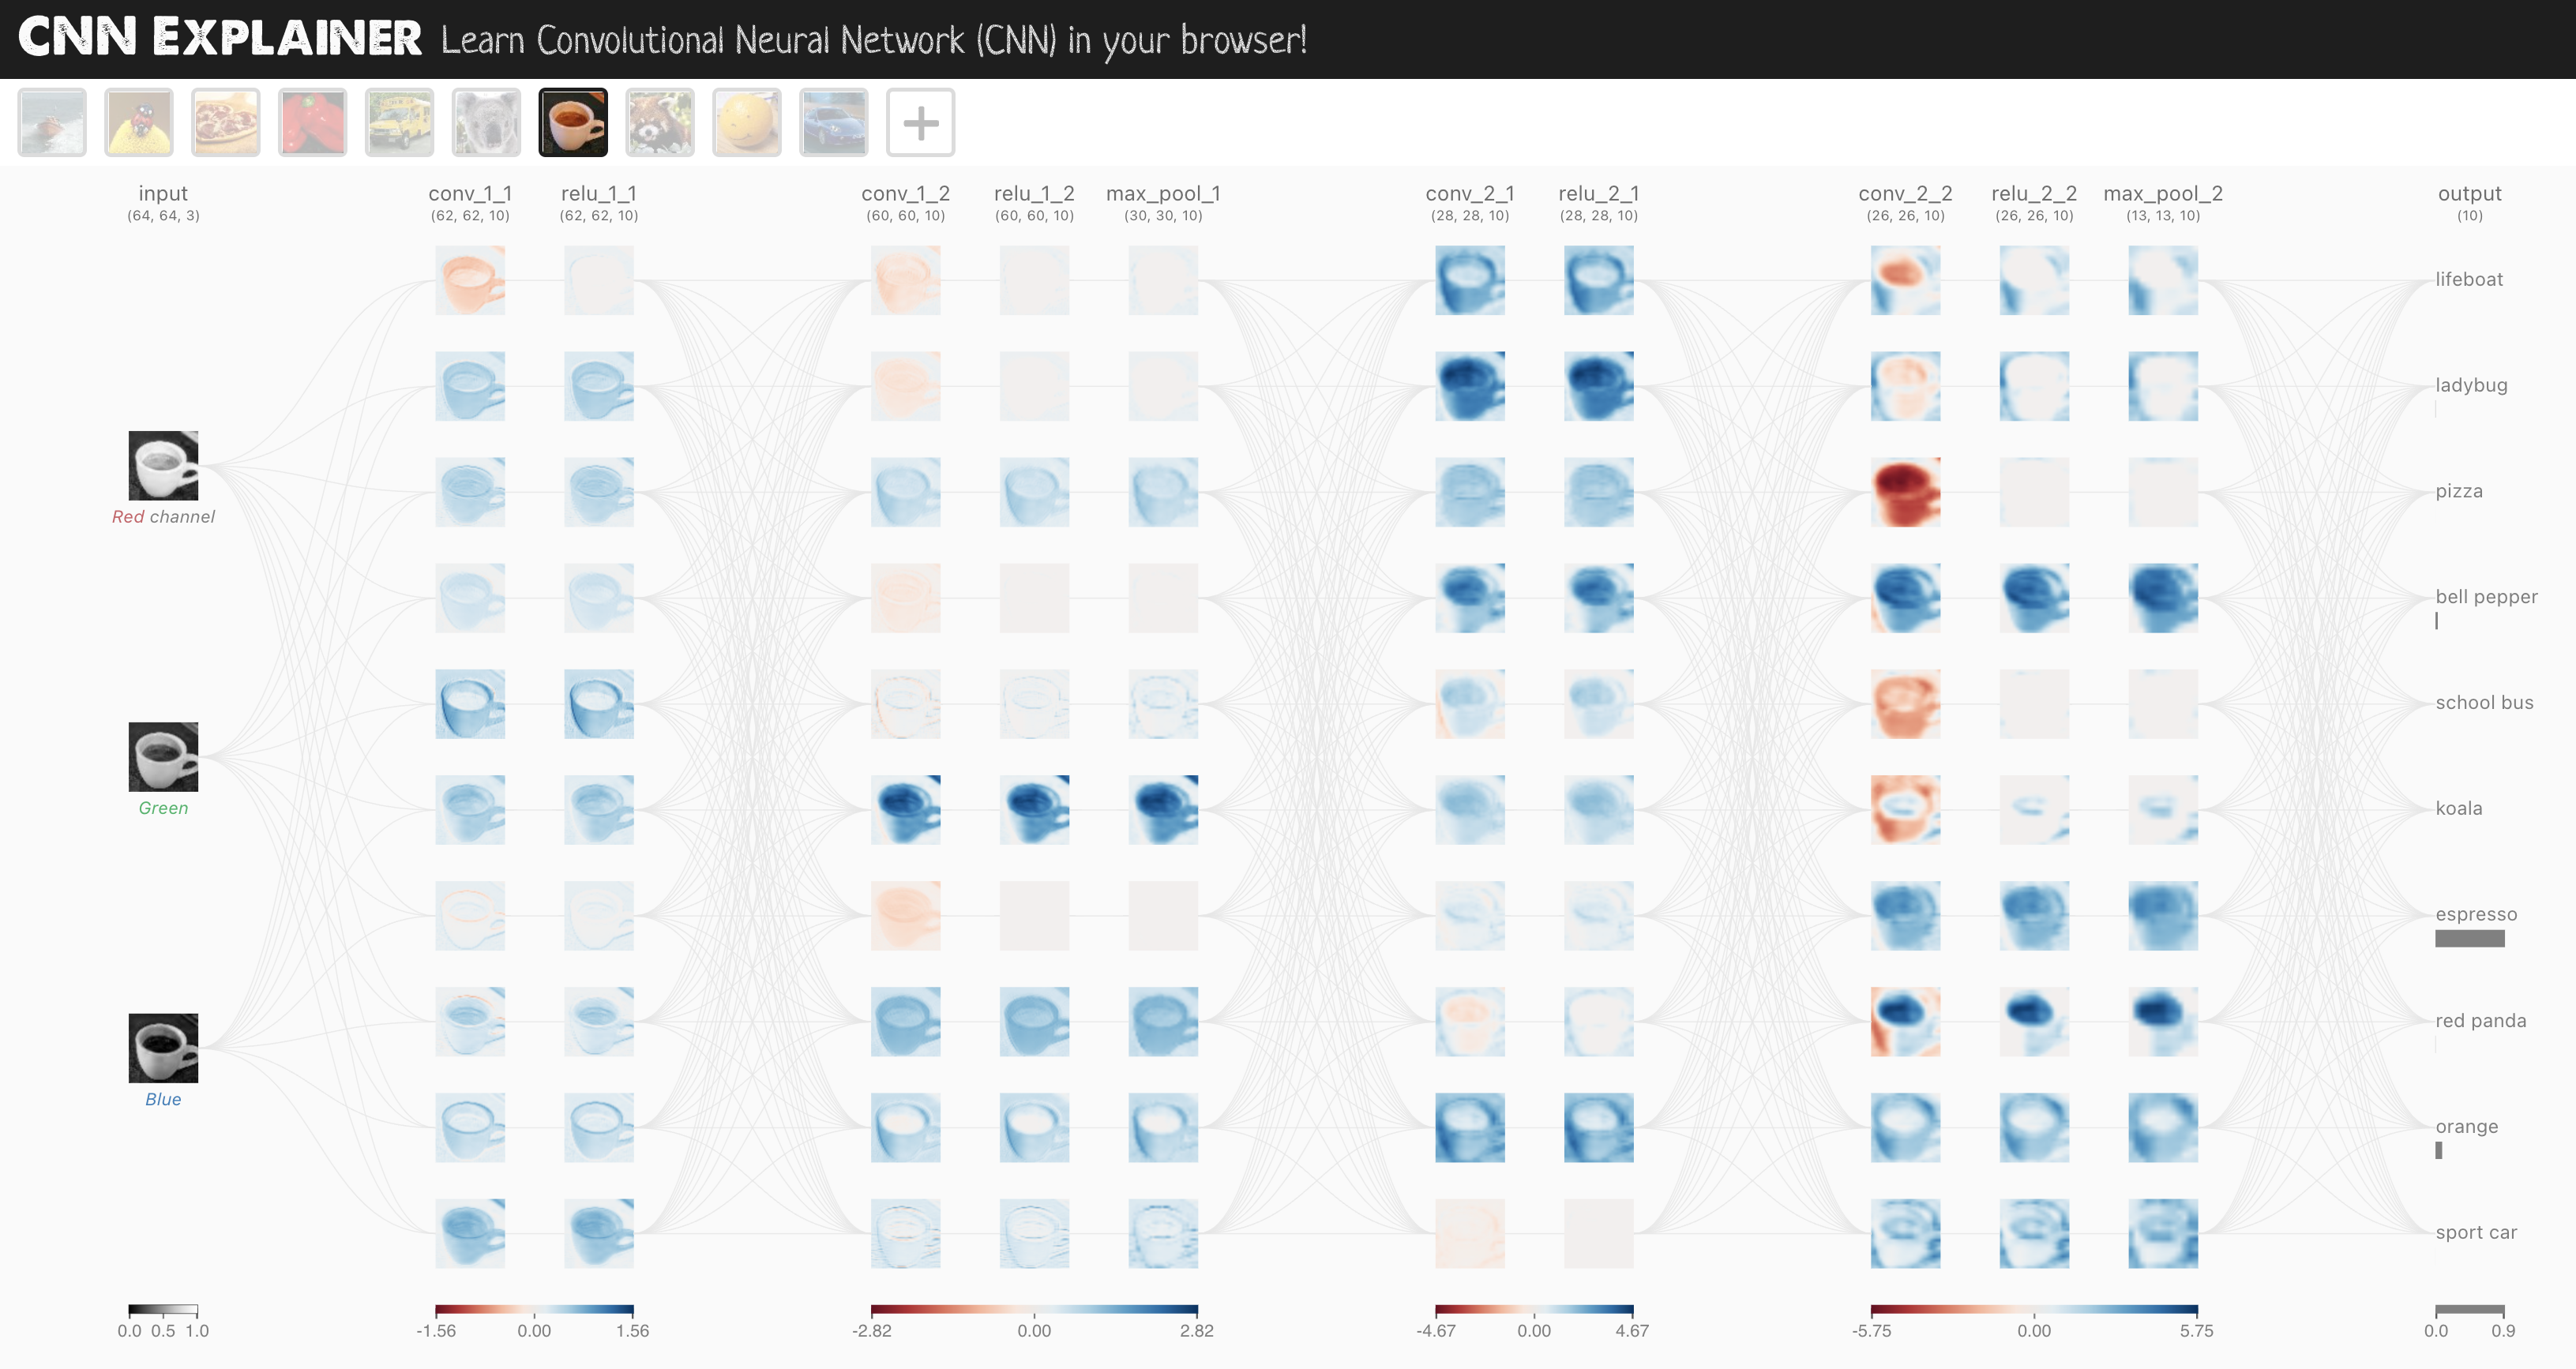

To do so, we'll leverage the [nn.Conv2d()](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [nn.MaxPool2d()](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) layers from torch.nn.



In [27]:
# Create a convolutional neural network 
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, # This shape comes from the fact that the block2 outbput has a shape of[batch_size, 10, 7, 7] after going through the cnn ans max polling layser.
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

# 6. Training:

Before training let's create an optimizer and loss function for the model2.

In [28]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

We'll use our train_step() and test_step() functions we created before.

We'll also measure the time to compare it to our other models.

In [31]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dl, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dl,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.36525 | Train accuracy: 86.83%
Test loss: 0.36465 | Test accuracy: 86.75%

Epoch: 1
---------
Train loss: 0.32859 | Train accuracy: 87.97%
Test loss: 0.33309 | Test accuracy: 87.72%

Epoch: 2
---------
Train loss: 0.30794 | Train accuracy: 88.86%
Test loss: 0.31026 | Test accuracy: 88.50%

Train time on cuda: 35.978 seconds


Let's evaluate model_2's results with our eval_model() function.

In [33]:
# Get model_2 results 
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dl,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.310256689786911,
 'model_acc': 88.49840255591054}

**We gonna compare the 3 models we have build so far.

In [34]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

model_name  model_loss  model_acc
0  FashionMNISTModelV0    0.477732  83.496406
1  FashionMNISTModelV1    0.685001  75.019968
2  FashionMNISTModelV2    0.310257  88.498403

In [35]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

model_name  model_loss  model_acc  training_time
0  FashionMNISTModelV0    0.477732  83.496406      26.192303
1  FashionMNISTModelV1    0.685001  75.019968      30.343061
2  FashionMNISTModelV2    0.310257  88.498403      35.977770

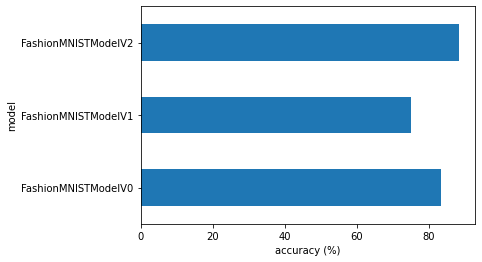

In [36]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

# 7. Making predictions: 

let's create a function to make some predictions on our test data:


In [37]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [38]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)



And now we can use our make_predictions() function to predict on test_samples.

In [39]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[5.2829e-08, 4.0230e-09, 1.9698e-08, 9.0115e-09, 3.3869e-09, 9.9995e-01,
         9.4693e-08, 3.7679e-06, 3.4351e-06, 4.5805e-05],
        [4.1489e-02, 8.3475e-01, 3.5054e-04, 2.9879e-02, 2.3775e-02, 1.9518e-05,
         6.9274e-02, 2.5189e-04, 6.5953e-05, 1.4719e-04]])

In [40]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [41]:
# Are our predictions in the same form as our test labels? 
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

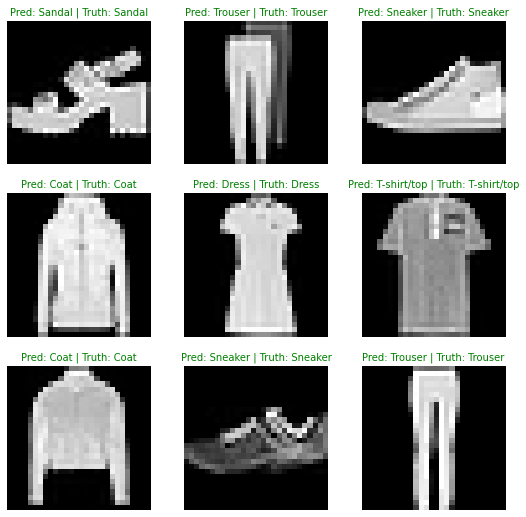

In [42]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

# 8. Making a confusion matrix for further prediction evaluations:

A confusion matrix shows you where your classification model got confused between predicitons and true labels.

To make a confusion matrix, we'll go through three steps:


1.   Make predictions with our trained model, model_2 (a confusion matrix compares predictions to true labels).

2.   Make a confusion matrix using torch.ConfusionMatrix.
3.   Plot the confusion matrix using mlxtend.plotting.plot_confusion_matrix().


Let's start by making predictions with our trained model.





In [44]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dl, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

Now we've got predictions, let's go through steps 2 & 3.


First we'll need to make sure we've got torchmetrics and mlxtend installed (these two libraries will help us make and visual a confusion matrix).

In [45]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.2 MB/s eta 0:00:00
mlxtend version: 0.21.0



To plot the confusion matrix, we need to make sure we've got and mlxtend version of 0.19.0 or higher.

In [46]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.21.0


torchmetrics and mlxtend installed, let's make a confusion matrix!

First we'll create a torchmetrics.ConfusionMatrix instance telling it how many classes we're dealing with by setting num_classes=len(class_names).

Then we'll create a confusion matrix (in tensor format) by passing our instance our model's predictions (preds=y_pred_tensor) and targets (target=test_data.targets).

Finally we can plot our confision matrix using the plot_confusion_matrix() function from mlxtend.plotting.

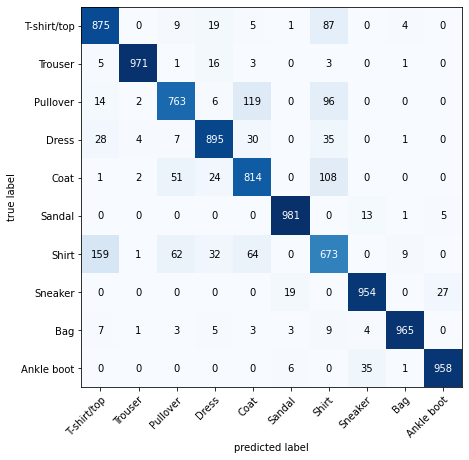

In [47]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);


Woah! Doesn't that look good?

We can see our model does fairly well since most of the dark squares are down the diagonal from top left to bottom right (and ideal model will have only values in these squares and 0 everywhere else).

The model gets most "confused" on classes that are similar, for example predicting "Pullover" for images that are actually labelled "Shirt".

And the same for predicting "Shirt" for classes that are actually labelled "T-shirt/top".

This kind of information is often more helpful than a single accuracy metric because it tells use where a model is getting things wrong.

It also hints at why the model may be getting certain things wrong.

It's understandable the model sometimes predicts "Shirt" for images labelled "T-shirt/top".

We can use this kind of information to further inspect our models and data to see how it could be improved.

# 9. Saving and reloading the model:

Let's finish this section off by saving and loading in our best performing model.

For now, let's save our model_2's state_dict() then load it back in and evaluate it to make sure the save and load went correctly.

In [48]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


Since we're using load_state_dict(), we'll need to create a new instance of FashionMNISTModelV2() with the same input parameters as our saved model state_dict().

In [49]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = FashionMNISTModelV2(input_shape=1, 
                                    hidden_units=10, # try changing this to 128 and seeing what happens 
                                    output_shape=10) 

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

And now we've got a loaded model we can evaluate it with eval_model() to make sure its parameters work similarly to model_2 prior to saving.

In [50]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dl,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.310256689786911,
 'model_acc': 88.49840255591054}

In [51]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.310256689786911,
 'model_acc': 88.49840255591054}


We can find out if two tensors are close to each other using torch.isclose() and passing in a tolerance level of closeness via the parameters atol (absolute tolerance) and rtol (relative tolerance).

In [52]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_2_results["model_loss"]), 
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)